In [0]:
cd /content/drive/My Drive/University/SEM7/CS4622_Machine_Learning/Project_1/Fair_Classification/

/content/drive/My Drive/University/SEM7/CS4622_Machine_Learning/Project_1/Fair_Classification


In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from datetime import datetime
import calendar
from math import sin, cos, sqrt, atan2, radians,asin
import folium
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
from folium.plugins import TimestampedGeoJson
from folium.plugins import MarkerCluster
from geopy.distance import great_circle
import matplotlib.dates as mdates
import matplotlib as mpl
from datetime import timedelta
import datetime as dt
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')
import folium
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import Imputer
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pickle
from geopy.distance import geodesic

In [0]:
train  = pd.read_csv("/content/drive/My Drive/University/SEM7/CS4622_Machine_Learning/Project_1/Fair_Classification/train.csv")
test  = pd.read_csv("/content/drive/My Drive/University/SEM7/CS4622_Machine_Learning/Project_1/Fair_Classification/test.csv")

train.head

<bound method NDFrame.head of           tripid  additional_fare  duration  ...  drop_lon    fare    label
0      189123628  10.5             834.0     ...  79.8783   270.32  correct
1      189125358  10.5             791.0     ...  79.8923   197.85  correct
2      189125719  10.5             1087.0    ...  79.9146   301.64  correct
3      189127273  10.5             598.0     ...  79.8971   82.30   correct
4      189128020 NaN              NaN        ...  79.9290   358.39  correct
...          ...  ..               ..        ...      ...      ...      ...
17171  213803193  10.5             838.0     ...  80.6557   198.26  correct
17172  213812756  10.5             2151.0    ...  79.9389   581.23  correct
17173  213813930  10.5             263.0     ...  79.9017   76.20   correct
17174  213815405  10.5             858.0     ...  79.9010   133.31  correct
17175  213817296  10.5             262.0     ...  79.9374   98.57   correct

[17176 rows x 14 columns]>

In [0]:
train['pickup_time']=pd.to_datetime(train['pickup_time'],infer_datetime_format=True)
train['drop_time']=pd.to_datetime(train['drop_time'],infer_datetime_format=True)

In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17176 entries, 0 to 17175
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   tripid                     17176 non-null  int64         
 1   additional_fare            16974 non-null  float64       
 2   duration                   16974 non-null  float64       
 3   meter_waiting              16974 non-null  float64       
 4   meter_waiting_fare         16974 non-null  float64       
 5   meter_waiting_till_pickup  16974 non-null  float64       
 6   pickup_time                17176 non-null  datetime64[ns]
 7   drop_time                  17176 non-null  datetime64[ns]
 8   pick_lat                   17176 non-null  float64       
 9   pick_lon                   17176 non-null  float64       
 10  drop_lat                   17176 non-null  float64       
 11  drop_lon                   17176 non-null  float64       
 12  fare

In [0]:
train.describe()

,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare,pickup_day,pickup_hour,pickup_month,pickup_year
count,1.717600e+04,16974.000000,16974.000000,16974.000000,16974.000000,16974.000000,17176.000000,17176.000000,17176.000000,17176.000000,17039.000000,17176.000000,17176.000000,17176.000000,17176.000000
mean,2.014549e+08,13.719651,1702.858077,629.074231,32.057666,112.466832,6.965499,79.998389,6.968587,79.997534,312.655466,15.903586,13.817536,7.955170,2019.339136
std,7.456830e+06,98.975052,8120.160818,8063.260669,465.483573,442.054812,0.210760,0.243384,0.378669,0.359648,605.300565,8.852767,4.824091,4.999059,0.473430
min,1.891236e+08,0.000000,0.000000,0.000000,0.000000,0.000000,5.937600,79.819100,5.941860,45.307700,0.000000,1.000000,0.000000,1.000000,2019.000000
25%,1.947619e+08,10.500000,548.000000,33.000000,0.000000,26.000000,6.865077,79.870400,6.865625,79.870100,125.515000,8.000000,10.000000,1.000000,2019.000000
50%,2.013582e+08,10.500000,1009.500000,123.000000,0.116600,73.000000,6.914105,79.898600,6.916160,79.899100,211.180000,16.000000,14.000000,11.000000,2019.000000
75%,2.083081e+08,10.500000,1803.000000,351.000000,14.341800,144.000000,7.043057,79.956600,7.047195,79.960225,366.465000,24.000000,18.000000,12.000000,2020.000000
max,2.138173e+08,12795.030000,453872.000000,453650.000000,26198.601400,51288.000000,8.051010,81.009600,48.132000,81.009700,26945.990000,31.000000,23.000000,12.000000,2020.000000


In [0]:
train['pickup_date']= train['pickup_time'].dt.date
train['pickup_day']=train['pickup_time'].apply(lambda x:x.day)
train['pickup_hour']=train['pickup_time'].apply(lambda x:x.hour)
train['pickup_day_of_week']=train['pickup_time'].apply(lambda x:calendar.day_name[x.weekday()])
train['pickup_month']=train['pickup_time'].apply(lambda x:x.month)
train['pickup_year']=train['pickup_time'].apply(lambda x:x.year)

In [0]:
train[pd.isnull(train)].sum()

Text(0.5, 1.0, 'Distribution of Trip Fare')

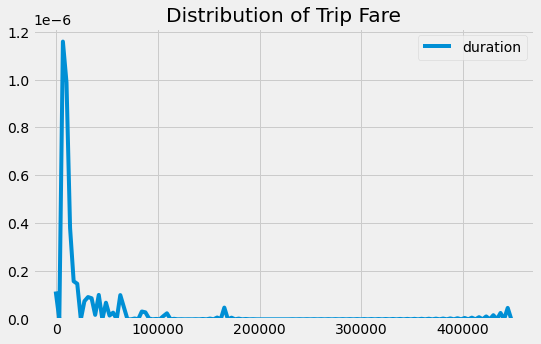

In [0]:
plt.figure(figsize=(8,5))
sns.kdeplot(test['duration']).set_title("Distribution of Trip Fare")

In [0]:
train.loc[train['meter_waiting_till_pickup']<0].shape

(0, 21)

In [0]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train['fare'].values)).set_title("Distribution of fare amount (log scale)")

In [0]:
print("Range of Pickup Latitude is ", (min(test['drop_lon']),max(test['drop_lon'])))

Range of Pickup Latitude is  (79.8177, 80.7764)


In [0]:
print("Range of Pickup Latitude is ", (min(test['pick_lat']),max(test['pick_lat'])))

Range of Pickup Latitude is  (5.94313, 8.42501)


In [0]:
test[(test.pick_lat==0) | (test.pick_lon)==0 | (test.drop_lat==0)|(test.drop_lon==0)].shape

(0, 13)

In [0]:
boundary={'min_lng':79.818,
              'min_lat':5.9366,
              'max_lng':80.8055, 
              'max_lat':8.42173}

In [0]:
train.loc[~((train.pick_lon >= boundary['min_lng'] ) & (train.pick_lon <= boundary['max_lng']) &
            (train.pick_lat >= boundary['min_lat']) & (train.pick_lat <= boundary['max_lat']) &
            (train.drop_lon >= boundary['min_lng']) & (train.drop_lon <= boundary['max_lng']) &
            (train.drop_lat >=boundary['min_lat']) & (train.drop_lat <= boundary['max_lat'])),'is_outlier_loc']=1
train.loc[((train.pick_lon >= boundary['min_lng'] ) & (train.pick_lon <= boundary['max_lng']) &
            (train.pick_lat >= boundary['min_lat']) & (train.pick_lat <= boundary['max_lat']) &
            (train.drop_lon >= boundary['min_lng']) & (train.drop_lon <= boundary['max_lng']) &
            (train.drop_lat >=boundary['min_lat']) & (train.drop_lat <= boundary['max_lat'])),'is_outlier_loc']=0

print("Outlier vs Non Outlier Counts")
print(train['is_outlier_loc'].value_counts())

# Let us drop rows, where location is outlier
train=train.loc[train['is_outlier_loc']==0]
train.drop(['is_outlier_loc'],axis=1,inplace=True)

Outlier vs Non Outlier Counts
0.0    17170
1.0    6    
Name: is_outlier_loc, dtype: int64


(5.9366, 8.42173)

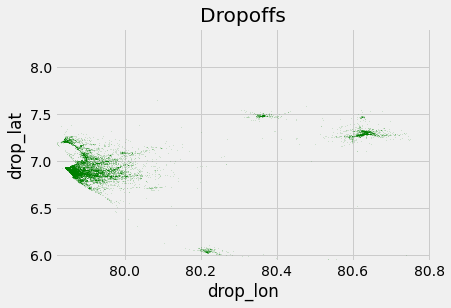

In [0]:
city_long_border = (79.818, 80.8055)
city_lat_border = (5.9366, 8.42173)

train.plot(kind='scatter', x='drop_lon', y='drop_lat',
                color='green', 
                s=.02, alpha=.6)
plt.title("Dropoffs")

plt.xlim(city_long_border)
plt.ylim(city_lat_border)


(79.818, 80.8055)

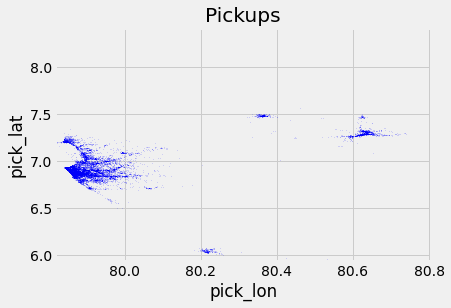

In [0]:
train.plot(kind='scatter', x='pick_lon', y='pick_lat',
                color='blue', 
                s=.02, alpha=.6)
plt.title("Pickups")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

In [0]:
train['pickup_latitude_round3']=train['pick_lat'].apply(lambda x:round(x,3))
train['pickup_longitude_round3']=train['pick_lon'].apply(lambda x:round(x,3))
train['dropoff_latitude_round3']=train['drop_lat'].apply(lambda x:round(x,3))
train['dropoff_longitude_round3']=train['drop_lon'].apply(lambda x:round(x,3))

In [0]:
pickup_fare_amount=train.groupby(['pickup_latitude_round3','pickup_longitude_round3'])['fare'].mean().reset_index().rename(columns={'fare':'avg_fare'})
pickup_fare_amount.head()

,pickup_latitude_round3,pickup_longitude_round3,avg_fare
0,5.938,80.513,219.010
1,5.944,80.549,142.870
2,5.945,80.549,241.745
3,5.945,80.550,165.760
4,5.945,80.553,162.660


# Trip Distance

In [0]:
#calculate trip distance in miles
def distance(lat1, lat2, lon1,lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

In [0]:
train['trip_distance']=train.apply(lambda row:distance(row['pick_lat'],row['drop_lat'],row['pick_lon'],row['drop_lon']),axis=1)

Text(0.5, 1.0, 'Distribution of Trip Distance (log scale)')

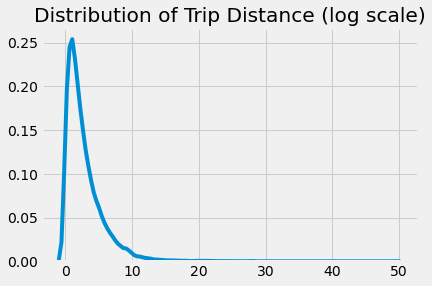

In [0]:
sns.kdeplot(train['trip_distance'].values).set_title("Distribution of Trip Distance (log scale)")

Text(0.5, 1.0, 'Trip Distance vs Fare Amount')

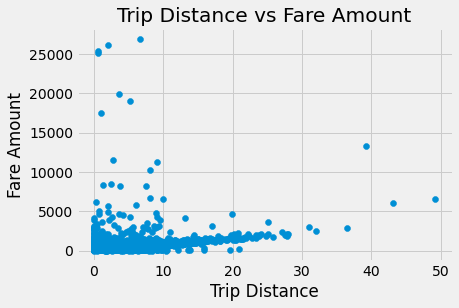

In [0]:
plt.scatter(x=train['trip_distance'],y=train['fare'])
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount")

In [0]:
train.to_csv("Train_FeatureEngineering.csv",index=False)

In [0]:
test.head

<bound method NDFrame.head of          tripid  additional_fare  duration  ...  drop_lat  drop_lon     fare
0     213284604  10.5             924       ...  6.77490   79.8840   289.27 
1     213286352  10.5             4249      ...  6.55091   79.9706   1912.70
2     213293973  10.5             1552      ...  6.90539   79.8989   394.00 
3     213294622  10.5             462       ...  6.80401   79.9407   154.32 
4     213298687  10.5             814       ...  6.98875   79.8914   147.47 
...         ...   ...             ...       ...      ...       ...      ... 
8571  222856243  10.5             1723      ...  6.85588   79.9214   388.48 
8572  222857785  10.5             1378      ...  6.92112   79.8980   379.85 
8573  222858416  10.5             418       ...  6.83868   79.9083   112.79 
8574  222858691  10.5             1604      ...  6.93159   79.9145   248.46 
8575  222860703  10.5             1698      ...  6.87020   79.9340   339.63 

[8576 rows x 13 columns]>